In [96]:
import json
import os
from collections import Counter, defaultdict



In [80]:
from functools import lru_cache
from tqdm.notebook import tqdm
with open("../trex/re-nlg_0-10000.json") as f:
    trex = json.load(f)

In [ ]:
from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api
prohibited_types = {
    "Q5",
    "Q3918",
    "Q783794",
    "Q2221906"
}

@lru_cache(maxsize=1000000)
def get_types_of_instance(instance_id):
    if not instance_id.startswith("Q"):
        return prohibited_types

    types = get_entity_dict_from_api(instance_id)

    if "claims" in types and "P31" in types["claims"]:
        instance_of = types["claims"]["P31"]
        return {instance["mainsnak"]["datavalue"]["value"]["id"] for instance in instance_of}
    else:
        return prohibited_types
        
        
def contains_prohibited(triples):
    for triple in triples:
        subj_types = get_types_of_instance(triple["subject"]["uri"].replace("http://www.wikidata.org/entity/",""))
        obj_types = get_types_of_instance(triple["object"]["uri"].replace("http://www.wikidata.org/entity/",""))

        if any(t in prohibited_types for t in subj_types.union(obj_types)):
            return True

    return False

def filter_distractor(i):
    sentence_triples = defaultdict(list)

    for trip in i['triples']:
        sentence_triples[trip['sentence_id']].append(trip)

    sentences = i["sentences_boundaries"]
    for sent_id,triples in sentence_triples.items():
        if contains_prohibited(triples):
            continue
        else:
            start,end = sentences[sent_id]
            yield i["text"][start:end]


from multiprocessing.pool import ThreadPool

distractor_sents = []

def get_all(p):
    pool = ThreadPool(processes=12)
    pmap = pool.imap_unordered
    for i in pmap(filter_distractor,p):
        yield from i

for sent in tqdm(filter(lambda i: i is not None, get_all(trex))):
    distractor_sents.append(sent)

Wikidata redirect detected.  Input entity id=Q11707850. Returned entity id=Q3221083.
Wikidata redirect detected.  Input entity id=Q3281788. Returned entity id=Q1367434.
Wikidata redirect detected.  Input entity id=Q47250. Returned entity id=Q27477249.
Wikidata redirect detected.  Input entity id=Q2455704. Returned entity id=Q164280.
Wikidata redirect detected.  Input entity id=Q3745054. Returned entity id=Q1160573.
Wikidata redirect detected.  Input entity id=Q2258363. Returned entity id=Q895060.
Wikidata redirect detected.  Input entity id=Q5641. Returned entity id=Q3407658.
Wikidata redirect detected.  Input entity id=Q152735. Returned entity id=Q16927441.
Wikidata redirect detected.  Input entity id=Q5019589. Returned entity id=Q2507067.
Wikidata redirect detected.  Input entity id=Q133226. Returned entity id=Q14763008.
Wikidata redirect detected.  Input entity id=Q1379. Returned entity id=Q25550430.
Wikidata redirect detected.  Input entity id=Q1079082. Returned entity id=Q380091.


In [104]:
print(len(distractor_sents))
for a in distractor_sents[:10]:
    print(a)

with open("distractors.txt","w+") as f:
    for line in distractor_sents:
        f.write(line+"\n")

11270
The Austroasiatic languages, in recent classifications synonymous with Mon–Khmer, are a large language family of continental Southeast Asia, also scattered throughout India, Bangladesh, Nepal and the southern border of China.
The name Austroasiatic comes from the Latin words for "south" and "Asia", hence "South Asia".
Of these languages, only Vietnamese, Khmer, and Mon have a long-established recorded history, and only Vietnamese and Khmer have official status (in Vietnam and Cambodia, respectively).
These form thirteen established families (plus perhaps Shompen, which is poorly attested, as a fourteenth), which have traditionally been grouped into two, as Mon–Khmer and Munda.
However, one recent classification posits three groups (Munda, Nuclear Mon-Khmer and Khasi-Khmuic) while another has abandoned Mon–Khmer as a taxon altogether, making it synonymous with the larger family.
In addition to mathematics and statistics, the arithmetic mean is used frequently in fields such as eco

In [106]:
def only_distractor(i):
    sentence_triples = defaultdict(list)

    for trip in i['triples']:
        sentence_triples[trip['sentence_id']].append(trip)

    sentences = i["sentences_boundaries"]
    for sent_id,triples in sentence_triples.items():
        if not contains_prohibited(triples):
            continue
        else:
            start,end = sentences[sent_id]
            yield i["text"][start:end]


from multiprocessing.pool import ThreadPool

similar_sents = []

def get_all(p):
    pool = ThreadPool(processes=12)
    pmap = pool.imap_unordered
    for i in pmap(only_distractor,p):
        yield from i

for sent in tqdm(filter(lambda i: i is not None, get_all(trex))):
    similar_sents.append(sent)

In [107]:
print(len(similar_sents))
for a in similar_sents[:10]:
    print(a)

with open("similar.txt","w+") as f:
    for line in similar_sents:
        f.write(line+"\n")




11561
The word was coined by the French philosopher Auguste Comte in French, as altruisme, for an antonym of egoism.
For example, per capita income is the arithmetic average income of a nation's population.
Alain Connes ([alɛ̃ kɔn]; born 1 April 1947) is a French mathematician, currently Professor at the Collège de France, IHÉS, The Ohio State University and Vanderbilt University.
Ayn Rand (/ˈaɪn ˈrænd/; born Alisa Zinov'yevna Rosenbaum, Russian: Али́са Зино́вьевна Розенба́ум; February 2 [O.S.
January 20] 1905 – March 6, 1982) was a Russian-born American novelist, philosopher, playwright, and screenwriter.
She is known for her two best-selling novels, The Fountainhead (1943) and Atlas Shrugged (1957), and for developing a philosophical system she called Objectivism.
Born and educated in Russia, Rand moved to the United States in 1926.
After two early novels that were initially unsuccessful in America, she achieved fame with her 1943 novel, The Fountainhead.
In 1957, she published her b

In [136]:
common_answer_true = {}
common_answer_sets = defaultdict(set)
for question, triple in created:
    q,a = question.split("?")
    q = q.strip()
    a = a.strip()

    if "(SET)" in a:
        a = a.replace("(SET)","").strip()
        common_answer_sets[q].add(a)
    else:
        common_answer_true[q] = a

for question, triple in created:
    item_type = item_types[triple["object"]["surfaceform"]]
    #print([item_types[t] for t in item_type])

print(common_answer_sets)


defaultdict(<class 'set'>, {'Apple Inc. produces which items': {'iPhone', 'iPod', 'Apple Watch', 'iPad'}, 'Commodore produces which items': {'C64'}, 'Audi produces which items': {'automobile'}, 'gonads produces which items': {'sex hormones'}, 'Airbus produces which items': {'airliner'}, 'brewing produces which items': {'beer'}, 'breweries produces which items': {'beer'}, 'Brewing produces which items': {'beer'}, 'Volkswagen produces which items': {'automobile'}, 'Renault produces which items': {'automobile'}, 'Be Inc. produces which items': {'BeOS'}, 'Mandrakesoft produces which items': {'Mandriva Linux'}, 'Mandriva produces which items': {'Mandriva Linux', 'Mandrake Linux'}, 'Commodore Business Machines (CBM) produces which items': {'C64', 'C128'}, 'CBM produces which items': {'C64', 'C-64'}, 'Commodore International produces which items': {'C64', 'C-64', 'Commodore 64'}, 'Commodore 64 produces which items': {'C64', 'C-64'}, 'The Coca-Cola Company produces which items': {'It'}, 'cocoa

In [ ]:
        #if trip['predicate']['surfaceform'] is not None:
            #print("{} {} {}".format(trip['subject']['surfaceform'],trip['predicate']['surfaceform'], trip['object']['surfaceform']))

        if trip['predicate']['uri'] in types:
            rel = types[trip['predicate']['uri']]
            for re in rel:
                pass
                #print("{} {} {}".format(trip['subject']['surfaceform'], re, trip['object']['surfaceform']))
        else:
            #print(trip['predicate']['uri'])
            pass

        if trip['predicate']['uri'] in questions:
            rel = questions[trip['predicate']['uri']]
            #for re in rel:
                #print(re.replace("$s",trip['subject']['surfaceform']).replace("$p",trip['object']['surfaceform']))


    #print(i['entities'])
    #print(i['entities'][0].keys())
    #for entity in i['entities']:
    #    print(entity['boundaries'])

print(len(trex))

417
[('http://www.wikidata.org/prop/direct/P17', 8318), ('http://www.wikidata.org/prop/direct/P47', 7763), ('http://www.wikidata.org/prop/direct/P31', 5462), ('http://www.wikidata.org/prop/direct/P279', 4409), ('http://www.wikidata.org/prop/direct/P27', 3301), ('http://www.wikidata.org/prop/direct/P131', 3058), ('http://www.wikidata.org/prop/direct/P530', 3049), ('http://www.wikidata.org/prop/direct/P361', 2767), ('http://www.wikidata.org/prop/direct/P106', 2719), ('http://www.wikidata.org/prop/direct/P527', 2333), ('http://www.wikidata.org/prop/direct/P569', 2153), ('http://www.wikidata.org/prop/direct/P570', 1915), ('http://www.wikidata.org/prop/direct/P463', 1835), ('http://www.wikidata.org/prop/direct/P37', 1511), ('http://www.wikidata.org/prop/direct/P1411', 1460), ('http://www.wikidata.org/prop/direct/P150', 1436), ('http://www.wikidata.org/prop/direct/P1412', 1074), ('http://www.wikidata.org/prop/direct/P136', 1013), ('http://www.wikidata.org/prop/direct/P138', 995), ('http://ww

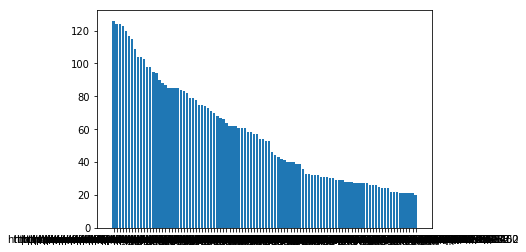

In [65]:
print(len(counter))
print(counter.most_common(100))

import matplotlib.pyplot as plt
rns = []
vs = []
for k,v in counter.most_common(200)[100:]:
    rns.append(k)
    vs.append(v)

plt.bar(rns,vs)
plt.show()
